# Comparison of regression models in predicting next-day stock returns

In [185]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
from joblib import dump, load

In [186]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [187]:
# TODO
# Selecting the tickers can be a stand-alone function
# Set the ticker
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one month ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=4)

df = pd.DataFrame()

# Get historical data for AAPL
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=1000,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)
    
df.index = df.index.date

# df.head()
len(df)

1000

In [188]:
print(df.head())
print(df.tail())

             AAPL    AMZN   GOOGL     NFLX
2016-07-14  98.79  741.19  735.78  98.0200
2016-07-15  98.76  735.43  735.64  98.3900
2016-07-18  99.83  736.07  753.42  98.8037
2016-07-19  99.87  740.06  753.41  85.8300
2016-07-20  99.93  745.72  757.08  87.9200
              AAPL     AMZN    GOOGL    NFLX
2020-06-26  353.69  2692.87  1362.14  443.39
2020-06-29  362.00  2681.52  1398.00  447.42
2020-06-30  364.60  2756.09  1417.92  454.75
2020-07-01  364.01  2879.20  1442.60  485.58
2020-07-02  364.12  2887.56  1469.80  477.22


## AAPL

### Create AAPL df

In [189]:
df = df['AAPL'].to_frame()
df.index = pd.to_datetime(df.index)
df.rename(columns={'AAPL': 'close'}, inplace=True)
df.dropna(inplace=True)

In [190]:
df.head()

,close
2016-07-14,98.79
2016-07-15,98.76
2016-07-18,99.83
2016-07-19,99.87
2016-07-20,99.93


In [191]:
short_window = 20
long_window = 100

# Return
df["return"] = df["close"].pct_change()

# Exponentially weighted moving average
df["short_window_ma"] = df["close"].ewm(halflife=short_window).mean()
df["long_window_ma"] = df["close"].ewm(halflife=long_window).mean()

# Expoentially weighted volatility
df["fast_vol"] = df["return"].ewm(halflife=short_window).std()
df["slow_vol"] = df["return"].ewm(halflife=long_window).std()

df.dropna(inplace=True)
df.drop(columns=['return'], inplace=True)

In [244]:
df.head(6)

,close,short_window_ma,long_window_ma,fast_vol,slow_vol
2016-07-18,99.83,99.138752,99.129072,0.007876,0.007876
2016-07-19,99.87,99.331175,99.316235,0.006231,0.006236
2016-07-20,99.93,99.459382,99.440695,0.005276,0.005307
2016-07-21,99.42,99.452237,99.437186,0.005815,0.005824
2016-07-22,98.66,99.326960,99.323837,0.006353,0.006359
2016-07-25,97.32,99.044628,99.067239,0.007736,0.007707


### Prep data for model fitting

In [192]:
# Split data by time segments of size `window` days
def window_data(df, window, feature_col_nums, target_col_num):
    X = []
    y = []
    
    for i in range(len(df) - window):
        X_comp = df.iloc[i:(i+window), feature_col_nums]
        y_comp = df.iloc[(i+window), target_col_num]
        X.append(X_comp.to_numpy())
        y.append(y_comp)
    return np.array(X), np.array(y).reshape(-1, 1)

In [251]:
window_size = 5 # Set to short_window?
X, y = window_data(df, window_size, 0, 0)

In [252]:
print(X[0])
print(y[0])

[[9.98300000e+01 9.91387522e+01 9.91290725e+01 7.87576972e-03
  7.87576972e-03]
 [9.98700000e+01 9.93311747e+01 9.93162347e+01 6.23074240e-03
  6.23577734e-03]
 [9.99300000e+01 9.94593817e+01 9.94406953e+01 5.27599863e-03
  5.30723578e-03]
 [9.94200000e+01 9.94522365e+01 9.94371861e+01 5.81528022e-03
  5.82407516e-03]
 [9.86600000e+01 9.93269603e+01 9.93238375e+01 6.35267476e-03
  6.35877051e-03]]
[97.32]


In [253]:
# Train/test split
train_size = 0.90
split = int(len(X) * train_size)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [254]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [255]:
# Since X is a list of arrays, need to call scaler on each sub array individually
# for sub_array in X:
#     scaler.fit(sub_array)

# X_scaled = [scaler.transform(sub_array) for sub_array in X]

# y_scaled = scaler.fit_transform(y)

scaler.fit(X.reshape(-1, 1))
# X_train_shape = X_train.shape
X_train = scaler.transform(X_train.reshape(-1, 1))
X_train = X_train.reshape((int(X_train.shape[0] / 25), 5, 5))
X_test = scaler.transform(X_test.reshape(-1, 1))
X_test = X_test.reshape((int(X_test.shape[0] / 25), 5, 5))

In [257]:
print(X_train[0])
print(X_test[0])
print(y_train[0])
print(y_test[0])

[[2.72473624e-01 2.70586849e-01 2.70560428e-01 7.09612831e-06
  7.09612831e-06]
 [2.72582805e-01 2.71112070e-01 2.71071291e-01 2.60599264e-06
  2.61973560e-06]
 [2.72746576e-01 2.71462014e-01 2.71411009e-01 0.00000000e+00
  8.52624482e-08]
 [2.71354520e-01 2.71442511e-01 2.71401430e-01 1.47198013e-06
  1.49598609e-06]
 [2.69280085e-01 2.71100567e-01 2.71092043e-01 2.93880951e-06
  2.95544798e-06]]
[[8.70320484e-01 7.91889136e-01 6.32603333e-01 2.98539549e-05
  2.96380711e-05]
 [8.77744780e-01 7.94813694e-01 6.34300032e-01 2.91609861e-05
  2.95065508e-05]
 [8.87652939e-01 7.97976140e-01 6.36053541e-01 2.85735340e-05
  2.93990407e-05]
 [8.73541318e-01 8.00550167e-01 6.37697222e-01 2.90004423e-05
  2.94486020e-05]
 [8.77635599e-01 8.03175980e-01 6.39357841e-01 2.82595167e-05
  2.92994230e-05]]
[0.26562253]
[0.87236762]


In [197]:
y_train[0]

array([0.00240158])

In [258]:
# Turn train, test into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [260]:
# Construct model

model = Sequential()

num_inputs = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=num_inputs,
    return_sequences=True,
    input_shape=(X_train.shape[1], 5)
))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units=num_inputs,
    return_sequences=True
))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units=num_inputs
))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [261]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [262]:
# Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total para

In [263]:
# Fit model
model.fit(X_train, y_train, batch_size=1, epochs=1, shuffle=False, verbose=1)

893/893 [==============================] - 32s 35ms/sample - loss: 0.0104


In [264]:
# Evaluate model
model.evaluate(X_test, y_test)

100/100 [==============================] - 2s 24ms/sample - loss: 0.0101


0.010107453763484955

In [265]:
print(f"X_test: {X_test[0]}")
print(f"y_test: {y_test[0]}")

X_test: [[8.70320484e-01 7.91889136e-01 6.32603333e-01 2.98539549e-05
  2.96380711e-05]
 [8.77744780e-01 7.94813694e-01 6.34300032e-01 2.91609861e-05
  2.95065508e-05]
 [8.87652939e-01 7.97976140e-01 6.36053541e-01 2.85735340e-05
  2.93990407e-05]
 [8.73541318e-01 8.00550167e-01 6.37697222e-01 2.90004423e-05
  2.94486020e-05]
 [8.77635599e-01 8.03175980e-01 6.39357841e-01 2.82595167e-05
  2.92994230e-05]]
y_test: [0.87236762]


In [269]:
predicted = model.predict(X_test)

# Inverse scale
real_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = scaler_y.inverse_transform(predicted)

predictions = pd.DataFrame({
    'Real': real_prices.ravel(),
    'Predicted': predicted_prices.ravel()
})

In [270]:
X_test.shape

(100, 5, 5)

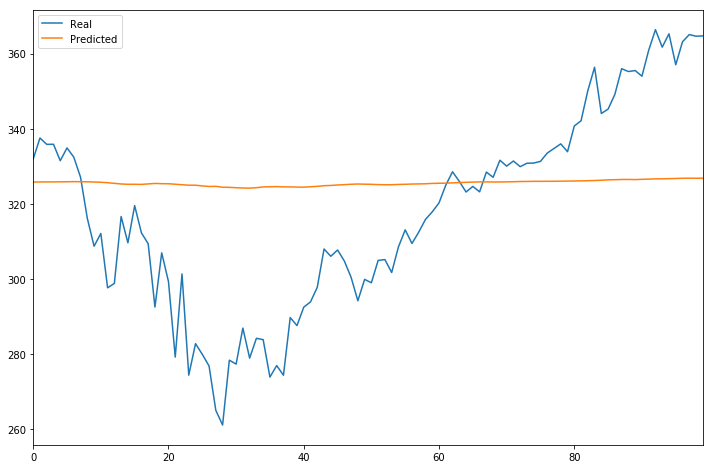

In [275]:
predictions.plot(figsize=(12,8))

In [233]:
scaler.inverse_transform(y_test.reshape(-1, 1))[:5]

array([[200.57],
       [210.52],
       [209.17],
       [211.78],
       [208.6 ]])

In [235]:
predicted[:5]

array([[0.32345948],
       [0.3234388 ],
       [0.3234265 ],
       [0.3234334 ],
       [0.32345456]], dtype=float32)